<a href="https://colab.research.google.com/github/r-diazp/deepL/blob/master/LTSM_Basico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#![pytorch icon.png](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQWyV5brHNCcNRsfWARFMR78N0Wg5V2hksMVYQeOpYnBn4zKOX2PPWky9wqxVoXuvnUi_s&usqp=CAU)

![pytorch icon.png](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

###- Understanding LSTM Networks https://colah.github.io/posts/2015-08-Understanding-LSTMs/
###- Fuente https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
For each element in the input sequence, an LSTM layer computes the following functions:<br>
$\begin{array}{ll} \\
    i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
    f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
    g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
    o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
    c_t = f_t * c_{(t-1)} + i_t * g_t \\
    h_t = o_t * \tanh(c_t) \\
\end{array}$ 

<br>$i_t, f_t, g_t, o_t$ are the input, forget, cell, and output gates, respectively.<br>
$h_t$ is the hidden state at time $t$, <br>
$c_t$ is the cell state at time $t$, <br>
$h_{(t-1)}$ is the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$, and <br>
$x_t$ is the input at time $t$, <br>

#Librerias

In [73]:
import torch
import torch.nn as nn

import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
#Revisar si la GPU esta habilitda y modelo 
print(f'- GPU available: {torch.cuda.is_available()} \
      \n- GPU: {torch.cuda.get_device_name(0)}')

- GPU available: True       
- GPU: Tesla T4


# Prepar Datos

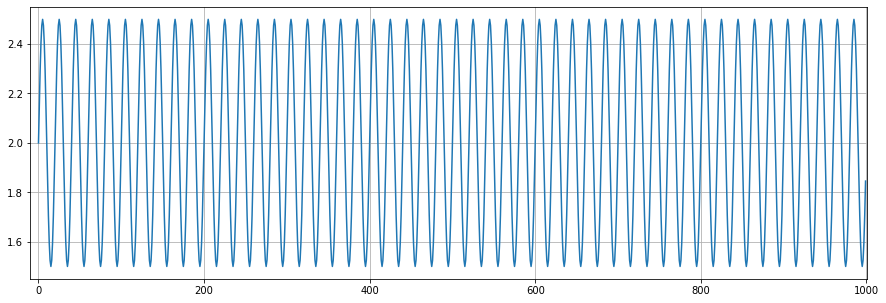

In [75]:
#Crear funcion de prueba 
x_point = 1000
T = 40
x = torch.linspace(0,x_point-1, steps=x_point)
fx = torch.sin(x*2*math.pi/T)*torch.cos(x*2*math.pi/T) + 2

plt.figure(figsize=(15,5))
plt.xlim(-10, x_point+1)
plt.grid(True)
plt.plot(fx.numpy());

#Set de datos
test_size = 40
train_set = fx[:-test_size].cuda()
test_set = fx[-test_size:].cuda()

In [76]:
#Funcion determinar ventana de los tensores 
def input_data(sequence, windows_size):  #Windows_size tamaño de la ventana 
    output = []
    L = len(sequence)
    for i in range(L - windows_size):
        window = sequence[i : i + windows_size]
        label = sequence[i + windows_size : i + windows_size+1]
        output.append((window, label))
    return output

In [77]:
#Crear datos de entrenamiento (Tuplas de Sequencia & etiquetas)
window_size = 40
train_data = input_data(train_set, window_size)

print(len(train_data)) #760-40
train_data[:2]

920


[(tensor([2.0000, 2.1545, 2.2939, 2.4045, 2.4755, 2.5000, 2.4755, 2.4045, 2.2939,
          2.1545, 2.0000, 1.8455, 1.7061, 1.5955, 1.5245, 1.5000, 1.5245, 1.5955,
          1.7061, 1.8455, 2.0000, 2.1545, 2.2939, 2.4045, 2.4755, 2.5000, 2.4755,
          2.4045, 2.2939, 2.1545, 2.0000, 1.8455, 1.7061, 1.5955, 1.5245, 1.5000,
          1.5245, 1.5955, 1.7061, 1.8455], device='cuda:0'),
  tensor([2.0000], device='cuda:0')),
 (tensor([2.1545, 2.2939, 2.4045, 2.4755, 2.5000, 2.4755, 2.4045, 2.2939, 2.1545,
          2.0000, 1.8455, 1.7061, 1.5955, 1.5245, 1.5000, 1.5245, 1.5955, 1.7061,
          1.8455, 2.0000, 2.1545, 2.2939, 2.4045, 2.4755, 2.5000, 2.4755, 2.4045,
          2.2939, 2.1545, 2.0000, 1.8455, 1.7061, 1.5955, 1.5245, 1.5000, 1.5245,
          1.5955, 1.7061, 1.8455, 2.0000], device='cuda:0'),
  tensor([2.1545], device='cuda:0'))]

# Arqutiectura Red Neuronal

In [79]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size) #Agregar una capa LSTM
        self.linear = nn.Linear(hidden_size, out_size) #Agregar Full connect 
        
        #Inicializar los tensores de dim 3 h0 y c0 (1, 1, 50) = 1 fila, 1 columa, 50 entradas para la capa pculta en la
        self.hidden = (torch.zeros(1,1,hidden_size), 
                       torch.zeros(1,1,hidden_size))
    
    
    def forward(self, sequence):
        lstm_out, self.hidden = self.lstm(sequence.view(len(sequence), 1, -1), self.hidden)
        prediction = self.linear(lstm_out.view(len(sequence),-1) )        
        return prediction[-1]   #Solo tomamos la ultima prediccion          

In [80]:
#Ejemplo Ho, Co
Neuronas = 50
Ho = torch.zeros(1, 1, Neuronas)
Co = torch.zeros(1, 1, Neuronas)

#Xt
tensores_mostrar = 5
print(f'-> {tensores_mostrar} PRIMEROS TENSORES DE Xt')
for Xt, y_train in train_data[:tensores_mostrar]:
  print(f'{Xt} ->TAMAÑO DEL TENSOR {len(Xt)} (IGUAL A LA VENTANA)')

print(f'\n-> Ho y Co INICIALIZADOS: \nTENSOR Ho: {Ho} ->TAMAÑO DEL TENSOR ES IGUAL A NUMERO DE NEURONAS DE LA CELDA LSTM CON DIM = {Ho.dim()} \
        \n\nTENSOR Co: {Co} ->TAMAÑO DEL TENSOR ES IGUAL A NUMERO DE NEURONAS DE LA CELDA LSTM CON DIM = {Co.dim()}')

-> 5 PRIMEROS TENSORES DE Xt
tensor([2.0000, 2.1545, 2.2939, 2.4045, 2.4755, 2.5000, 2.4755, 2.4045, 2.2939,
        2.1545, 2.0000, 1.8455, 1.7061, 1.5955, 1.5245, 1.5000, 1.5245, 1.5955,
        1.7061, 1.8455, 2.0000, 2.1545, 2.2939, 2.4045, 2.4755, 2.5000, 2.4755,
        2.4045, 2.2939, 2.1545, 2.0000, 1.8455, 1.7061, 1.5955, 1.5245, 1.5000,
        1.5245, 1.5955, 1.7061, 1.8455], device='cuda:0') ->TAMAÑO DEL TENSOR 40 (IGUAL A LA VENTANA)
tensor([2.1545, 2.2939, 2.4045, 2.4755, 2.5000, 2.4755, 2.4045, 2.2939, 2.1545,
        2.0000, 1.8455, 1.7061, 1.5955, 1.5245, 1.5000, 1.5245, 1.5955, 1.7061,
        1.8455, 2.0000, 2.1545, 2.2939, 2.4045, 2.4755, 2.5000, 2.4755, 2.4045,
        2.2939, 2.1545, 2.0000, 1.8455, 1.7061, 1.5955, 1.5245, 1.5000, 1.5245,
        1.5955, 1.7061, 1.8455, 2.0000], device='cuda:0') ->TAMAÑO DEL TENSOR 40 (IGUAL A LA VENTANA)
tensor([2.2939, 2.4045, 2.4755, 2.5000, 2.4755, 2.4045, 2.2939, 2.1545, 2.0000,
        1.8455, 1.7061, 1.5955, 1.5245, 1.5000,

In [81]:
#Instanciar modelo
#Modelo en GPU
torch.manual_seed(20)
gpu_model = LSTM(hidden_size=60).cuda()
criterion = nn.MSELoss()
gpu_optimizer = torch.optim.SGD(gpu_model.parameters(), lr=0.01)
print(f'- gpu_model (cuda): {next(gpu_model.parameters()).is_cuda}')
print(f'\nARQUITECTURA: \n{gpu_model}')

- gpu_model (cuda): True

ARQUITECTURA: 
LSTM(
  (lstm): LSTM(1, 60)
  (linear): Linear(in_features=60, out_features=1, bias=True)
)


# Entrenar Red Neuronal LSTM

Epoch:  1 Loss: 0.00964187
Loss en predicciones en test: 0.14973405003547668


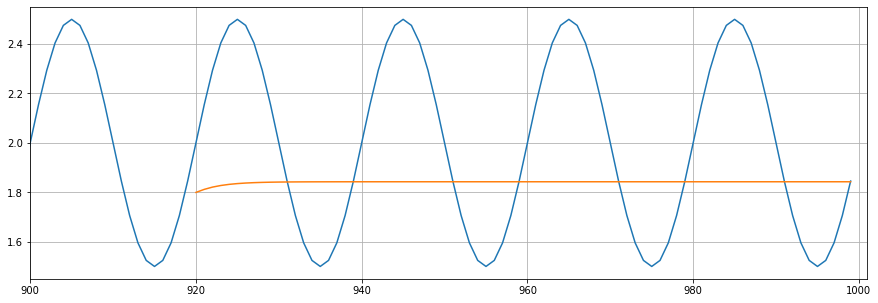

Epoch:  2 Loss: 0.01344902
Loss en predicciones en test: 0.15157587826251984


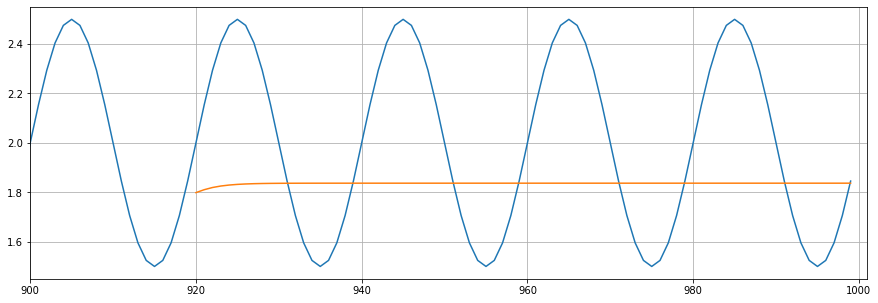

Epoch:  3 Loss: 0.01533622
Loss en predicciones en test: 0.15299993753433228


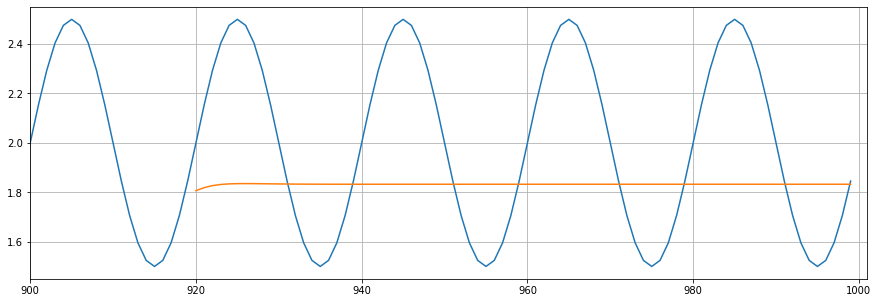

Epoch:  4 Loss: 0.01348443
Loss en predicciones en test: 0.1515675038099289


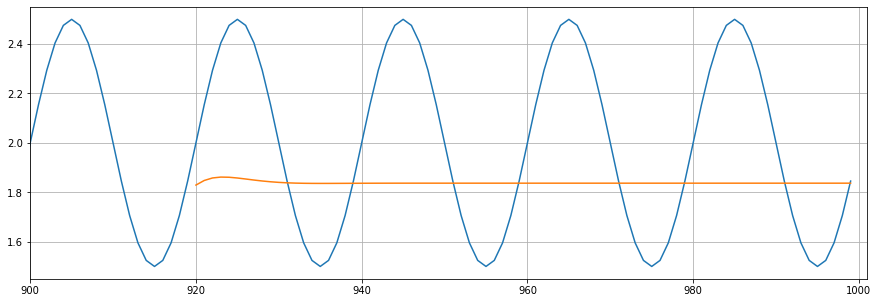

Epoch:  5 Loss: 0.00657510
Loss en predicciones en test: 0.1436537206172943


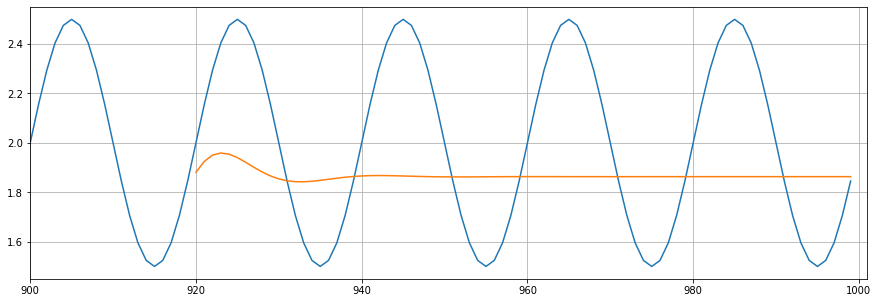

Epoch:  6 Loss: 0.00035111
Loss en predicciones en test: 0.13728107511997223


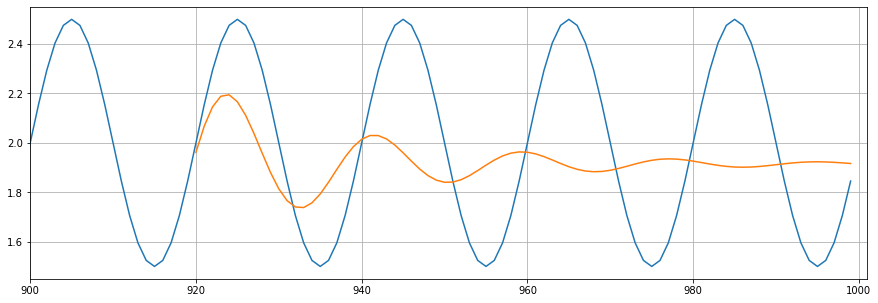

Epoch:  7 Loss: 0.00011461
Loss en predicciones en test: 0.10666098445653915


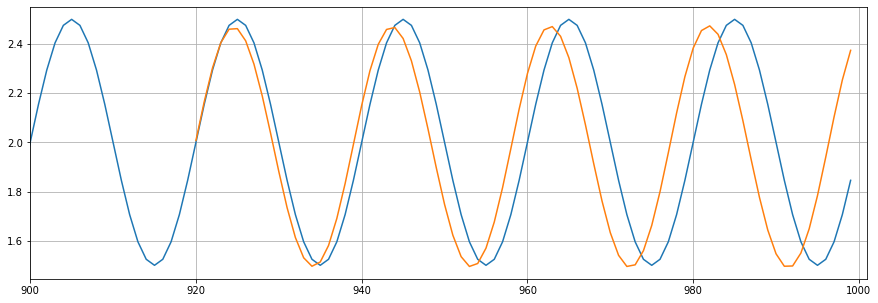

Epoch:  8 Loss: 0.00002025
Loss en predicciones en test: 0.004328250885009766


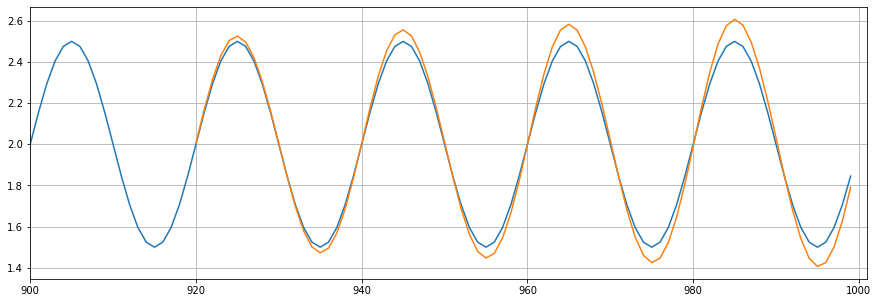

Epoch:  9 Loss: 0.00000155
Loss en predicciones en test: 0.00024092334206216037


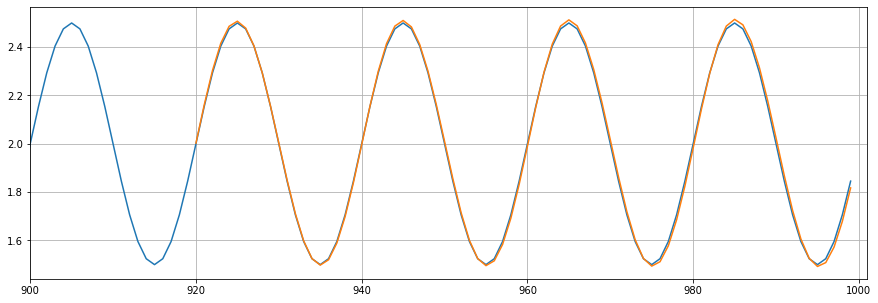

Epoch: 10 Loss: 0.00000148
Loss en predicciones en test: 5.3144944104133174e-05


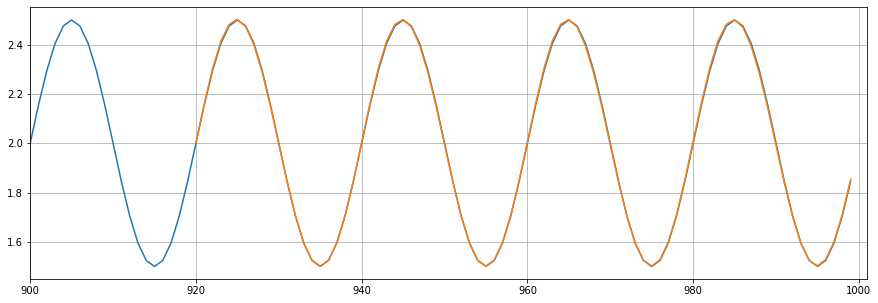


Duration: 21 seconds


In [82]:
#@ Entrenar con GPU
epochs =  10#@param {type:"integer"}
validate = 80 #@param {type:"integer"}
start_time = time.time()

for epoch in range(epochs):       
  for sequence, y_train in train_data: #sequence es Xt
    #Resetear estados
    gpu_optimizer.zero_grad()
    gpu_model.hidden = (torch.zeros(1, 1, gpu_model.hidden_size).cuda(),                        
                        torch.zeros(1, 1, gpu_model.hidden_size).cuda())
    
    y_pred = gpu_model(sequence)        
    loss = criterion(y_pred, y_train)
    loss.backward()
    gpu_optimizer.step()
  print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')


  #HACER PREDICCIONES  
  predicition = train_set[-window_size:].tolist()
  for f in range(validate):  
      sequence_test = torch.FloatTensor(predicition[-window_size:]).cuda()
      with torch.no_grad():
          gpu_model.hidden = (torch.zeros(1,1,gpu_model.hidden_size).cuda(),
                              torch.zeros(1,1,gpu_model.hidden_size).cuda())       

          predicition.append(gpu_model(sequence_test).item())
          
  loss = criterion(torch.tensor(predicition[-window_size:]),fx[x_point-window_size:])
  print(f'Loss en predicciones en test: {loss}')

  #Grafica de las prediciones 
  plt.figure(figsize=(15,5))
  plt.xlim(x_point-100, x_point+1)
  plt.grid(True)
  plt.plot(fx.numpy())
  plt.plot(range(x_point-validate, x_point),predicition[window_size:])
  plt.show()

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

#Probar modelo

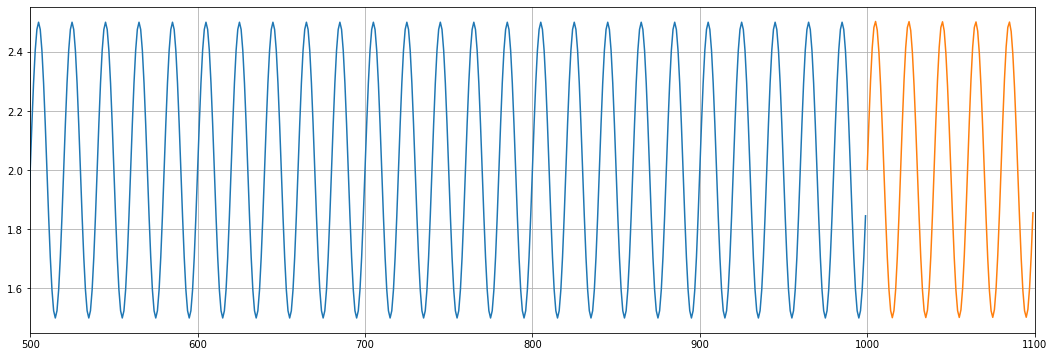

In [83]:
pred_future = 100
predicition = fx[-window_size:].tolist()
for i in range(pred_future):  
    sequence = torch.FloatTensor(predicition[-window_size:]).cuda()
    with torch.no_grad():        
        gpu_model.hidden = (torch.zeros(1,1,gpu_model.hidden_size).cuda(), #Reset parametros
                            torch.zeros(1,1,gpu_model.hidden_size).cuda())  

        predicition.append(gpu_model(sequence).item())
        
#Grafica de la predicciones 
plt.figure(figsize=(18,6))
plt.xlim(x_point*.5, x_point + pred_future)
plt.grid(True)
plt.plot(fx.numpy())
plt.plot(range(x_point, x_point + pred_future),predicition[window_size:])
plt.show()